In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

In [2]:
train_df = pd.read_csv('clean_data.csv')
val_df = pd.read_csv('clean_val.csv')
test_df = pd.read_csv('clean_test.csv')

In [3]:
train_df.dropna(inplace = True)

In [4]:
train_df.isnull().sum().sum()

0

In [5]:
with open("numerical.txt", "r", encoding="utf-8") as file:
    numeric_features = [line.strip() for line in file.readlines()]
    
with open("cat.txt", "r", encoding="utf-8") as file:
    cat_features = [line.strip() for line in file.readlines()]

In [6]:
print(train_df[cat_features[3]].unique())

['Entire home/apt' 'Private room' 'Shared room']


In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lambdas_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        for column in X.columns:
            if any(X[column] <= 0):
                X[column] = X[column] + abs(X[column].min()) + 1
            _, lambda_optimal = stats.boxcox(X[column])
            self.lambdas_[column] = lambda_optimal
        return self

    def transform(self, X):
        X = X.copy()
        for column, lambda_optimal in self.lambdas_.items():
            if any(X[column] <= 0):
                X[column] = X[column] + abs(X[column].min()) + 1
            X[column] = stats.boxcox(X[column], lmbda=lambda_optimal)
        return X

In [9]:
numeric_transformer = Pipeline([
    ('boxcox', BoxCoxTransformer()),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

preprocessor.fit(train_df)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('boxcox',
                                                  BoxCoxTransformer()),
                                                 ('scaler', StandardScaler())]),
                                 ['accommodates', 'bathrooms', 'bedrooms',
                                  'beds', 'cleaning_fee', 'guests_included',
                                  'availability_30', 'availability_365',
                                  'number_of_reviews']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['suburb', 'property_type', 'city',
                                  'room_type', 'doub...
                                  'tennis_court', 'elevator',
                                  'family/kid_friendly', 'tv',
                                  'air_conditioning', 'high_chair',
                                  'dishwasher', 'brick_oven',
     

In [10]:
class MyDataset(Dataset):
    def __init__(self, data, norm_target, target, preprocessor):
        self.features = preprocessor.transform(data)
        self.norm_target = torch.tensor(norm_target.values, dtype=torch.float32)
        self.target = torch.tensor(target.values, dtype=torch.float32)

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, index):
        feature = torch.tensor(self.features[index].toarray(), dtype=torch.float32) 
        norm_target = self.norm_target[index]
        target = self.target[index] 
        return feature, norm_target, target

In [11]:
def normalize(x):
    return (x - train_df['price'].min()) / (train_df['price'].max() - train_df['price'].min())

def denormalize(x):
    return x * (train_df['price'].max() - train_df['price'].min()) + train_df['price'].min()


In [12]:
train_df['normalized_price'] = train_df['price'].apply(normalize)
val_df['normalized_price'] = val_df['price'].apply(normalize)
test_df['normalized_price'] = test_df['price'].apply(normalize)

In [13]:
batch_size = 32

train_X = train_df[numeric_features + cat_features]
train_norm_y = train_df['normalized_price']
train_y = train_df['price']

val_X = val_df[numeric_features + cat_features]
val_norm_y = val_df['normalized_price']
val_y = val_df['price']

test_X = test_df[numeric_features + cat_features]
test_norm_y = test_df['normalized_price']
test_y = test_df['price']

train_dataset = MyDataset(train_df, train_norm_y, train_y, preprocessor=preprocessor)
val_dataset = MyDataset(val_df, val_norm_y, val_y, preprocessor=preprocessor)
test_dataset = MyDataset(test_df, test_norm_y, test_y, preprocessor=preprocessor)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)


In [1]:
class MLPRegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(MLPRegressionModel, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        
        self.fc3 = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.bn1(x)        
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)        
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        return x

NameError: name 'nn' is not defined

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [16]:
preprocessor.transform(train_X).shape[1]

723

In [17]:
input_dim = preprocessor.transform(train_X).shape[1]
model = MLPRegressionModel(input_dim=input_dim)
model = model.to(device)

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [19]:
import time
import math
from tqdm import tqdm

def rmse(y, y_predict):
    mse = mean_squared_error(y, y_predict)
    return math.sqrt(mse)

def train(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    for batch in tqdm(data_loader, desc="Training", unit="batch"):
        inputs, norm_targets, targets = batch
        inputs = inputs.view(inputs.size(0), -1).to(device)
        norm_targets = norm_targets.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, norm_targets.unsqueeze(1))
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        outputs = denormalize(outputs)
        
        all_preds.extend(outputs.cpu().tolist())
        all_labels.extend(targets.cpu().tolist())
        
    avg_loss = total_loss/len(data_loader)
    train_mae = mean_absolute_error(all_labels, all_preds)
    train_rmse = rmse(all_labels, all_preds)

    end_time = time.time()  
    epoch_duration = end_time - start_time  
    
    print(f'Training Loss: {avg_loss:.4f}, Train MAE: {train_mae:.4f}, Train RMSE: {train_rmse:.4f}, Time: {epoch_duration:.2f} seconds')
    return avg_loss, train_mae

def evaluate(model, data_loader, criterion, device):
    
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Validation", unit="batch"):
            
            inputs, norm_targets, targets = batch
            inputs = inputs.view(inputs.size(0), -1).to(device)
            norm_targets = norm_targets.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, norm_targets.unsqueeze(1))
            total_loss += loss.item()
            
            outputs = denormalize(outputs)
            all_preds.extend(outputs.cpu().tolist())
            all_labels.extend(targets.cpu().tolist())
    

    avg_loss = total_loss/len(data_loader)
    val_mae = mean_absolute_error(all_labels, all_preds)
    val_rmse = rmse(all_labels, all_preds)

    end_time = time.time()  
    epoch_duration = end_time - start_time  
    
    print(f'Validation Loss: {avg_loss:.4f}, Validation MAE: {val_mae:.4f}, Validation RMSE: {val_rmse:.4f}, Time: {epoch_duration:.2f} seconds')
    
    return avg_loss, val_mae

In [20]:
best_val_loss = float('inf')  
best_val_mae = float('inf')              
model_save_path = "2a.pth"

num_epochs = 50

train_losses = []
val_losses = []
train_mae_scores = []
val_mae_scores = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    train_loss, train_mae = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_mae = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)  
    train_mae_scores.append(train_mae)  
    val_losses.append(val_loss)  
    val_mae_scores.append(val_mae)  
    
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), model_save_path)   
        print(f"Best model saved with validation MAE: {best_val_mae:.4f}")

    print('-' * 100)

Epoch 1/50


Training: 100%|███████████████████████████████████████████████████████████████████| 561/561 [00:06<00:00, 89.29batch/s]


Training Loss: 0.0261, Train MAE: 87.1300, Train RMSE: 129.6724, Time: 6.32 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 241.97batch/s]


Validation Loss: 0.1213, Validation MAE: 59.1230, Validation RMSE: 280.3374, Time: 0.30 seconds
Best model saved with validation MAE: 59.1230
----------------------------------------------------------------------------------------------------
Epoch 2/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 118.43batch/s]


Training Loss: 0.0090, Train MAE: 47.6484, Train RMSE: 76.3168, Time: 4.77 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 195.66batch/s]


Validation Loss: 0.1193, Validation MAE: 58.4873, Validation RMSE: 278.3601, Time: 0.37 seconds
Best model saved with validation MAE: 58.4873
----------------------------------------------------------------------------------------------------
Epoch 3/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 125.01batch/s]


Training Loss: 0.0082, Train MAE: 44.8310, Train RMSE: 72.7196, Time: 4.52 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 209.26batch/s]


Validation Loss: 0.1189, Validation MAE: 55.4038, Validation RMSE: 277.8949, Time: 0.35 seconds
Best model saved with validation MAE: 55.4038
----------------------------------------------------------------------------------------------------
Epoch 4/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 118.56batch/s]


Training Loss: 0.0079, Train MAE: 43.9840, Train RMSE: 71.4634, Time: 4.77 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 207.56batch/s]


Validation Loss: 0.1192, Validation MAE: 53.4759, Validation RMSE: 278.2725, Time: 0.35 seconds
Best model saved with validation MAE: 53.4759
----------------------------------------------------------------------------------------------------
Epoch 5/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 124.55batch/s]


Training Loss: 0.0077, Train MAE: 42.9695, Train RMSE: 70.3963, Time: 4.54 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 208.04batch/s]


Validation Loss: 0.1195, Validation MAE: 53.3266, Validation RMSE: 277.2590, Time: 0.35 seconds
Best model saved with validation MAE: 53.3266
----------------------------------------------------------------------------------------------------
Epoch 6/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 119.92batch/s]


Training Loss: 0.0074, Train MAE: 42.4649, Train RMSE: 69.1363, Time: 4.71 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 206.43batch/s]


Validation Loss: 0.1199, Validation MAE: 52.2468, Validation RMSE: 279.0029, Time: 0.36 seconds
Best model saved with validation MAE: 52.2468
----------------------------------------------------------------------------------------------------
Epoch 7/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 123.45batch/s]


Training Loss: 0.0073, Train MAE: 42.4496, Train RMSE: 68.6770, Time: 4.58 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 209.44batch/s]


Validation Loss: 0.1197, Validation MAE: 53.3521, Validation RMSE: 278.6098, Time: 0.35 seconds
----------------------------------------------------------------------------------------------------
Epoch 8/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 121.41batch/s]


Training Loss: 0.0073, Train MAE: 42.0983, Train RMSE: 68.4743, Time: 4.65 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 206.85batch/s]


Validation Loss: 0.1190, Validation MAE: 52.0405, Validation RMSE: 277.9881, Time: 0.36 seconds
Best model saved with validation MAE: 52.0405
----------------------------------------------------------------------------------------------------
Epoch 9/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 121.61batch/s]


Training Loss: 0.0069, Train MAE: 41.4201, Train RMSE: 66.7254, Time: 4.65 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 210.12batch/s]


Validation Loss: 0.1183, Validation MAE: 58.2865, Validation RMSE: 277.1063, Time: 0.35 seconds
----------------------------------------------------------------------------------------------------
Epoch 10/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 122.45batch/s]


Training Loss: 0.0069, Train MAE: 41.2375, Train RMSE: 66.7939, Time: 4.62 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 200.74batch/s]


Validation Loss: 0.1197, Validation MAE: 51.8175, Validation RMSE: 278.7950, Time: 0.37 seconds
Best model saved with validation MAE: 51.8175
----------------------------------------------------------------------------------------------------
Epoch 11/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 119.93batch/s]


Training Loss: 0.0067, Train MAE: 40.8187, Train RMSE: 65.9480, Time: 4.71 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 208.81batch/s]


Validation Loss: 0.1190, Validation MAE: 53.1964, Validation RMSE: 277.9703, Time: 0.35 seconds
----------------------------------------------------------------------------------------------------
Epoch 12/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 115.49batch/s]


Training Loss: 0.0067, Train MAE: 40.7995, Train RMSE: 65.7490, Time: 4.89 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 204.78batch/s]


Validation Loss: 0.1179, Validation MAE: 51.8998, Validation RMSE: 276.7247, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 13/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:05<00:00, 112.02batch/s]


Training Loss: 0.0066, Train MAE: 40.5416, Train RMSE: 65.0293, Time: 5.04 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 208.57batch/s]


Validation Loss: 0.1175, Validation MAE: 51.7919, Validation RMSE: 276.2234, Time: 0.35 seconds
Best model saved with validation MAE: 51.7919
----------------------------------------------------------------------------------------------------
Epoch 14/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 114.28batch/s]


Training Loss: 0.0065, Train MAE: 40.1967, Train RMSE: 64.6994, Time: 4.94 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 206.85batch/s]


Validation Loss: 0.1193, Validation MAE: 54.3476, Validation RMSE: 278.2896, Time: 0.35 seconds
----------------------------------------------------------------------------------------------------
Epoch 15/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:05<00:00, 111.40batch/s]


Training Loss: 0.0063, Train MAE: 39.3515, Train RMSE: 63.6197, Time: 5.07 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 204.75batch/s]


Validation Loss: 0.1196, Validation MAE: 55.0183, Validation RMSE: 277.6854, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 16/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 114.61batch/s]


Training Loss: 0.0063, Train MAE: 39.6023, Train RMSE: 63.5059, Time: 4.93 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 207.23batch/s]


Validation Loss: 0.1184, Validation MAE: 51.8111, Validation RMSE: 277.2847, Time: 0.35 seconds
----------------------------------------------------------------------------------------------------
Epoch 17/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:05<00:00, 112.07batch/s]


Training Loss: 0.0062, Train MAE: 39.5650, Train RMSE: 63.2688, Time: 5.04 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 206.82batch/s]


Validation Loss: 0.1175, Validation MAE: 52.1292, Validation RMSE: 276.2534, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 18/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 114.51batch/s]


Training Loss: 0.0060, Train MAE: 38.6423, Train RMSE: 62.1258, Time: 4.93 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 200.52batch/s]


Validation Loss: 0.1178, Validation MAE: 52.9469, Validation RMSE: 276.6303, Time: 0.37 seconds
----------------------------------------------------------------------------------------------------
Epoch 19/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 112.38batch/s]


Training Loss: 0.0060, Train MAE: 39.0634, Train RMSE: 62.1450, Time: 5.03 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 197.06batch/s]


Validation Loss: 0.1180, Validation MAE: 51.0238, Validation RMSE: 276.8495, Time: 0.37 seconds
Best model saved with validation MAE: 51.0238
----------------------------------------------------------------------------------------------------
Epoch 20/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 114.10batch/s]


Training Loss: 0.0059, Train MAE: 39.1053, Train RMSE: 61.6425, Time: 4.95 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 208.31batch/s]


Validation Loss: 0.1181, Validation MAE: 51.2729, Validation RMSE: 276.9073, Time: 0.35 seconds
----------------------------------------------------------------------------------------------------
Epoch 21/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 115.27batch/s]


Training Loss: 0.0058, Train MAE: 38.5407, Train RMSE: 61.3548, Time: 4.90 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 205.39batch/s]


Validation Loss: 0.1181, Validation MAE: 51.2816, Validation RMSE: 276.9745, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 22/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 120.61batch/s]


Training Loss: 0.0056, Train MAE: 38.2976, Train RMSE: 60.3436, Time: 4.69 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 203.34batch/s]


Validation Loss: 0.1183, Validation MAE: 51.1688, Validation RMSE: 277.0202, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 23/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 121.98batch/s]


Training Loss: 0.0057, Train MAE: 38.3633, Train RMSE: 60.6907, Time: 4.63 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 175.58batch/s]


Validation Loss: 0.1182, Validation MAE: 52.6502, Validation RMSE: 277.0466, Time: 0.42 seconds
----------------------------------------------------------------------------------------------------
Epoch 24/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 120.80batch/s]


Training Loss: 0.0056, Train MAE: 38.0061, Train RMSE: 60.3100, Time: 4.68 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 206.52batch/s]


Validation Loss: 0.1182, Validation MAE: 51.5460, Validation RMSE: 277.0850, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 25/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 121.55batch/s]


Training Loss: 0.0056, Train MAE: 38.0593, Train RMSE: 60.0533, Time: 4.65 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 203.35batch/s]


Validation Loss: 0.1177, Validation MAE: 51.5834, Validation RMSE: 276.5185, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 26/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 119.16batch/s]


Training Loss: 0.0054, Train MAE: 37.6525, Train RMSE: 59.1725, Time: 4.74 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 206.81batch/s]


Validation Loss: 0.1184, Validation MAE: 51.6478, Validation RMSE: 277.1791, Time: 0.35 seconds
----------------------------------------------------------------------------------------------------
Epoch 27/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 121.72batch/s]


Training Loss: 0.0054, Train MAE: 37.6357, Train RMSE: 59.2514, Time: 4.64 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 209.25batch/s]


Validation Loss: 0.1175, Validation MAE: 51.0893, Validation RMSE: 276.2151, Time: 0.35 seconds
----------------------------------------------------------------------------------------------------
Epoch 28/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 117.58batch/s]


Training Loss: 0.0055, Train MAE: 37.7254, Train RMSE: 59.4402, Time: 4.80 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 207.28batch/s]


Validation Loss: 0.1176, Validation MAE: 51.9672, Validation RMSE: 276.4233, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 29/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 122.12batch/s]


Training Loss: 0.0055, Train MAE: 37.8842, Train RMSE: 59.4784, Time: 4.63 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 207.96batch/s]


Validation Loss: 0.1180, Validation MAE: 51.5307, Validation RMSE: 276.7745, Time: 0.35 seconds
----------------------------------------------------------------------------------------------------
Epoch 30/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 119.72batch/s]


Training Loss: 0.0053, Train MAE: 37.4183, Train RMSE: 58.7300, Time: 4.72 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 204.73batch/s]


Validation Loss: 0.1175, Validation MAE: 52.0832, Validation RMSE: 276.2187, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 31/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 122.87batch/s]


Training Loss: 0.0052, Train MAE: 37.0668, Train RMSE: 57.6913, Time: 4.60 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 177.46batch/s]


Validation Loss: 0.1177, Validation MAE: 51.5205, Validation RMSE: 276.4306, Time: 0.41 seconds
----------------------------------------------------------------------------------------------------
Epoch 32/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 119.14batch/s]


Training Loss: 0.0053, Train MAE: 37.3343, Train RMSE: 58.3827, Time: 4.74 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 184.58batch/s]


Validation Loss: 0.1180, Validation MAE: 52.7916, Validation RMSE: 276.9080, Time: 0.40 seconds
----------------------------------------------------------------------------------------------------
Epoch 33/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 117.14batch/s]


Training Loss: 0.0053, Train MAE: 37.2394, Train RMSE: 58.2844, Time: 4.82 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 177.87batch/s]


Validation Loss: 0.1185, Validation MAE: 53.8314, Validation RMSE: 277.3259, Time: 0.41 seconds
----------------------------------------------------------------------------------------------------
Epoch 34/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 119.68batch/s]


Training Loss: 0.0051, Train MAE: 36.8862, Train RMSE: 57.2653, Time: 4.72 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 206.86batch/s]


Validation Loss: 0.1182, Validation MAE: 52.2774, Validation RMSE: 277.0591, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 35/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 121.89batch/s]


Training Loss: 0.0052, Train MAE: 36.9297, Train RMSE: 57.6764, Time: 4.64 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 207.76batch/s]


Validation Loss: 0.1188, Validation MAE: 52.0782, Validation RMSE: 277.4711, Time: 0.35 seconds
----------------------------------------------------------------------------------------------------
Epoch 36/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 119.50batch/s]


Training Loss: 0.0052, Train MAE: 37.1743, Train RMSE: 58.0211, Time: 4.73 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 206.24batch/s]


Validation Loss: 0.1179, Validation MAE: 52.9024, Validation RMSE: 276.7312, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 37/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 120.95batch/s]


Training Loss: 0.0050, Train MAE: 36.3502, Train RMSE: 56.6436, Time: 4.67 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 203.57batch/s]


Validation Loss: 0.1186, Validation MAE: 52.8673, Validation RMSE: 277.5091, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 38/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 119.41batch/s]


Training Loss: 0.0052, Train MAE: 37.0321, Train RMSE: 57.9905, Time: 4.73 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 203.35batch/s]


Validation Loss: 0.1179, Validation MAE: 52.0949, Validation RMSE: 276.4396, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 39/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 116.50batch/s]


Training Loss: 0.0050, Train MAE: 36.5277, Train RMSE: 56.7506, Time: 4.85 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 173.05batch/s]


Validation Loss: 0.1179, Validation MAE: 51.7612, Validation RMSE: 276.7276, Time: 0.42 seconds
----------------------------------------------------------------------------------------------------
Epoch 40/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 122.24batch/s]


Training Loss: 0.0050, Train MAE: 36.4917, Train RMSE: 56.7105, Time: 4.62 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 207.16batch/s]


Validation Loss: 0.1183, Validation MAE: 52.1428, Validation RMSE: 276.3893, Time: 0.35 seconds
----------------------------------------------------------------------------------------------------
Epoch 41/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 120.81batch/s]


Training Loss: 0.0049, Train MAE: 36.0900, Train RMSE: 56.0033, Time: 4.68 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 205.39batch/s]


Validation Loss: 0.1177, Validation MAE: 52.6237, Validation RMSE: 276.5335, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 42/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 125.24batch/s]


Training Loss: 0.0048, Train MAE: 36.0681, Train RMSE: 55.9059, Time: 4.51 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 201.93batch/s]


Validation Loss: 0.1177, Validation MAE: 53.1483, Validation RMSE: 276.5201, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 43/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 119.14batch/s]


Training Loss: 0.0049, Train MAE: 36.2540, Train RMSE: 56.1341, Time: 4.74 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 203.07batch/s]


Validation Loss: 0.1175, Validation MAE: 51.5074, Validation RMSE: 276.3047, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 44/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 122.65batch/s]


Training Loss: 0.0048, Train MAE: 35.9631, Train RMSE: 55.3525, Time: 4.61 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 205.22batch/s]


Validation Loss: 0.1174, Validation MAE: 51.0837, Validation RMSE: 276.1582, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 45/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 116.82batch/s]


Training Loss: 0.0048, Train MAE: 35.9084, Train RMSE: 55.6416, Time: 4.84 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 211.72batch/s]


Validation Loss: 0.1173, Validation MAE: 52.6182, Validation RMSE: 276.0160, Time: 0.35 seconds
----------------------------------------------------------------------------------------------------
Epoch 46/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 122.28batch/s]


Training Loss: 0.0046, Train MAE: 35.8861, Train RMSE: 54.6445, Time: 4.62 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 209.24batch/s]


Validation Loss: 0.1187, Validation MAE: 51.3967, Validation RMSE: 276.4460, Time: 0.35 seconds
----------------------------------------------------------------------------------------------------
Epoch 47/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 121.10batch/s]


Training Loss: 0.0049, Train MAE: 35.9821, Train RMSE: 55.8693, Time: 4.67 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 177.31batch/s]


Validation Loss: 0.1176, Validation MAE: 51.4041, Validation RMSE: 276.4115, Time: 0.41 seconds
----------------------------------------------------------------------------------------------------
Epoch 48/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 123.26batch/s]


Training Loss: 0.0047, Train MAE: 35.9500, Train RMSE: 55.0947, Time: 4.58 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 206.26batch/s]


Validation Loss: 0.1177, Validation MAE: 51.0593, Validation RMSE: 276.5396, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------
Epoch 49/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 122.13batch/s]


Training Loss: 0.0047, Train MAE: 35.7465, Train RMSE: 54.9140, Time: 4.62 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 207.69batch/s]


Validation Loss: 0.1175, Validation MAE: 51.0551, Validation RMSE: 276.2885, Time: 0.35 seconds
----------------------------------------------------------------------------------------------------
Epoch 50/50


Training: 100%|██████████████████████████████████████████████████████████████████| 561/561 [00:04<00:00, 122.25batch/s]


Training Loss: 0.0047, Train MAE: 35.8014, Train RMSE: 55.1314, Time: 4.62 seconds


Validation: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 204.80batch/s]

Validation Loss: 0.1180, Validation MAE: 51.4479, Validation RMSE: 276.7354, Time: 0.36 seconds
----------------------------------------------------------------------------------------------------


In [21]:
epochs = [i for i in range(1, 51)]

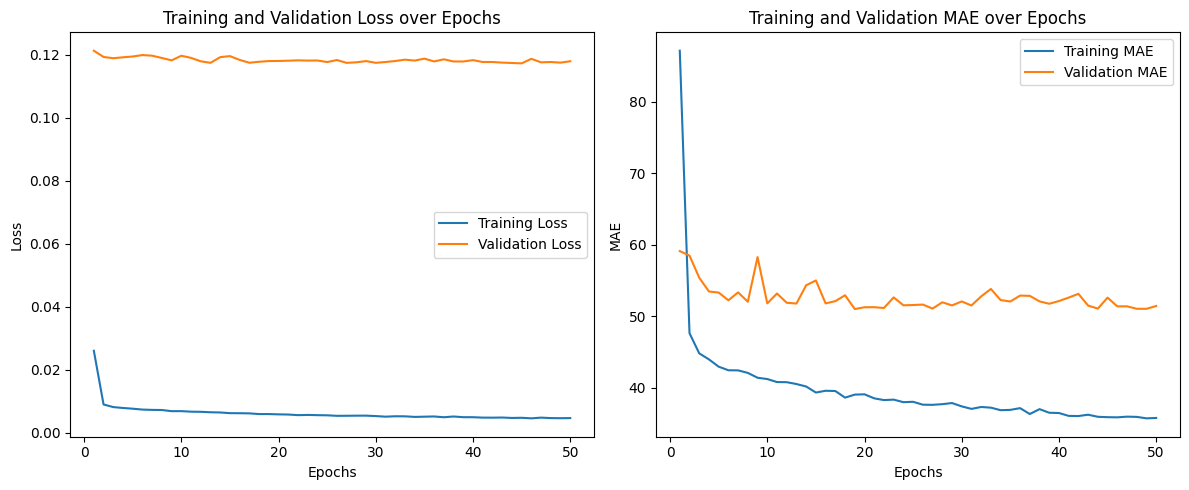

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, train_mae_scores, label="Training MAE")
plt.plot(epochs, val_mae_scores, label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training and Validation MAE over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
model1 = MLPRegressionModel(input_dim=input_dim)
model1.to(device)

model1.load_state_dict(torch.load(model_save_path))
model1.to(device)
all_labels = []
all_preds = []

start_time = time.time()

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing", unit="batch"):

        inputs, norm_targets, targets = batch
        inputs = inputs.view(inputs.size(0), -1).to(device)
        norm_targets = norm_targets.to(device)
        targets = targets.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, norm_targets.unsqueeze(1))
        outputs = denormalize(outputs)
        all_preds.extend(outputs.cpu().tolist())
        all_labels.extend(targets.cpu().tolist())
        
all_labels = np.array(all_labels).flatten()
all_preds = np.array(all_preds).flatten()
        
test_mae = mean_absolute_error(all_labels, all_preds)
test_rmse = rmse(all_labels, all_preds)

end_time = time.time()  
epoch_duration = end_time - start_time

print(f'Testing MAE: {test_mae:.4f}, Testing RMSE: {test_rmse:.4f}, Time: {epoch_duration:.2f} seconds')

Testing: 100%|█████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 207.16batch/s]

Testing MAE: 46.5775, Testing RMSE: 136.6218, Time: 0.35 seconds
